# Initializations

In [ ]:
!git clone https://github.com/Morteza-24/CVPRW2019_Face_Artifacts.git

Cloning into 'CVPRW2019_Face_Artifacts'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 122 (delta 3), reused 10 (delta 2), pack-reused 106 (from 1)
Receiving objects: 100% (122/122), 73.21 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (33/33), done.


In [ ]:
!pip install tf-slim
!pip install opencv-python==3.4.18.65
!pip install --upgrade "tensorflow<=2.10"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv CVPRW2019_Face_Artifacts/* ./
!unzip drive/MyDrive/ckpt_res50.zip
!mkdir ckpt_res50
!mv model.* ckpt_res50/
!mkdir train_imgs
!mkdir test_imgs

Archive:  drive/MyDrive/ckpt_res50.zip
 extracting: model.data-00000-of-00001  
 extracting: model.index             
 extracting: model.meta              


In [ ]:
import os, cv2
import numpy as np

rng = np.random.default_rng()

def sample_frames_from_videos(src, dst, num_frames=5):
  vids = os.listdir(src)
  for vid in vids:
    cap = cv2.VideoCapture(src+vid)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = sorted(set(rng.choice(length-2, size=num_frames, replace=False)))
    for frame in frames:
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
      _, img = cap.read()
      cv2.imwrite(dst+f'{vid}_{frame}.jpg', img)

In [ ]:
sample_frames_from_videos('drive/MyDrive/CELEBDF_V2/Real/', 'test_imgs/rC_')
sample_frames_from_videos('drive/MyDrive/CELEBDF_V2/Fake/', 'test_imgs/fC_')

In [ ]:
!cd test_imgs; mv `ls | sort -R | sed -n 1~4p` ../train_imgs/

In [ ]:
!ls -1 test_imgs | wc -l;
!ls -1 train_imgs | wc -l;
# ~25%

382
128


In [ ]:
!mkdir -p test_imgs/real
!mkdir -p test_imgs/fake
!mv test_imgs/rC* test_imgs/real/
!mv test_imgs/fC* test_imgs/fake/

# Tests Before Fine-Tuning

In [ ]:
!python demo.py --input_dir=test_imgs/real > real_results.txt

2024-09-23 16:36:28.693131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 16:36:28.877270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-09-23 16:36:28.877328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-23 16:36:28.932956: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 16:36:29.8941

In [ ]:
!python demo.py --input_dir=test_imgs/fake > fake_results.txt

2024-09-23 16:39:25.745184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 16:39:25.937991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-09-23 16:39:25.938028: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-23 16:39:25.994012: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 16:39:27.1034

In [ ]:
y_true = []
y_pred = []
with open("real_results.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    if line.startswith("Prob:"):
      prob = float(line.split(" ")[1][:-1])
      y_pred.append(prob)
      y_true.append(0)
with open("fake_results.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    if line.startswith("Prob:"):
      prob = float(line.split(" ")[1][:-1])
      y_pred.append(prob)
      y_true.append(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

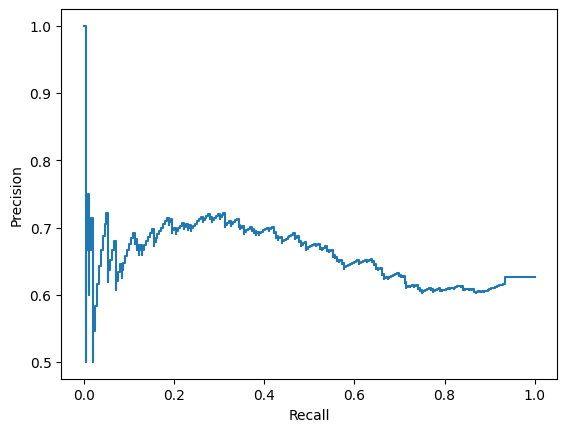

threshold: -1.0
f-score: 0.7697262479871175
precision: 1.0
recall: 0.6256544502617801
accuracy: 0.5942408376963351


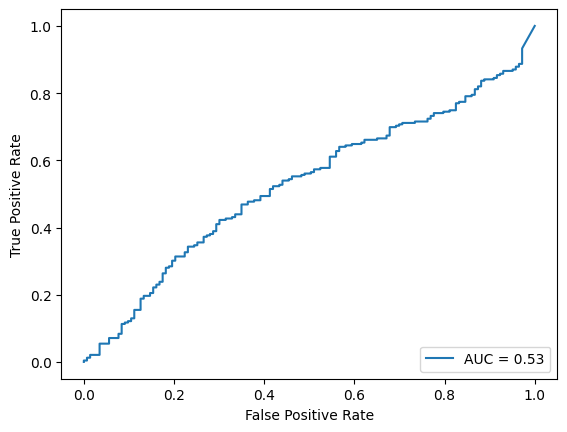

threshold: 0.3777135
accuracy: 0.5235602094240838
MCC: 0.11771074114170349


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, accuracy_score,
                             confusion_matrix, roc_auc_score, roc_curve,
                             matthews_corrcoef, auc,
                             RocCurveDisplay, PrecisionRecallDisplay, auc)

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print("threshold:", thresholds[ix])
print("f-score:", fscore[ix])
print("precision:", recall[ix])
print("recall:", precision[ix])

print("accuracy:", accuracy_score(y_true, y_pred>thresholds[ix]))

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

ix = np.argmax(tpr - fpr)
print("threshold:", thresholds[ix])
print("accuracy:", accuracy_score(y_true, y_pred>thresholds[ix]))
print("MCC:", matthews_corrcoef(y_true, y_pred>thresholds[ix]))

# Fine-Tuning

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from data_proc_train import DataProcTrain
from resolution_network import ResoNet
from solver import Solver
from easydict import EasyDict as edict
import yaml, numpy as np


cfg_file = 'cfgs/res50.yml'
with open(cfg_file, 'r') as f:
    cfg = edict(yaml.safe_load(f))

data_gen = DataProcTrain(
    face_img_dir="train_imgs",
    cache_path="landmarks.p",
    batch_size=cfg.TRAIN.BATCH_SIZE,
    is_shuffle=True)

tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True
cfg.TRAIN.DECAY_STEP = data_gen.batch_num
epoch = cfg.TRAIN.NUM_EPOCH

with tf.compat.v1.Session() as sess:
    reso_net = ResoNet(cfg=cfg, is_train=True)
    reso_net.build()
    solver = Solver(sess=sess, cfg=cfg, net=reso_net)
    solver.init()
    count = 0
    for epoch_id in range(epoch):
        for i in range(data_gen.batch_num):
            data = data_gen.get_batch(i, resize=cfg.IMG_SIZE[:2])
            images = data['images']
            labels = data['images_label']
            # ims_tmp = vis_im(images, 'tmp/vis.jpg')
            # summary, prob, net_loss, total_loss, weights = solver.train(images, labels)
            summary, prob, net_loss, total_loss = solver.train(images, labels)
            pred_labels = np.argmax(prob, axis=1)
            print('====================================')
            print('Net loss: {}'.format(net_loss))
            print('Total loss: {}'.format(total_loss))
            print('Real label: {}'.format(np.array(labels)))
            print('Pred label: {}'.format(pred_labels))
            # print('Neg hard mining: {}'.format(weights))
            print('epoch: {}, batch_idx: {}'.format(epoch_id, i))
            # if count % 100 == 0:
            #     solver.writer.add_summary(summary, count)
            # count += 1

        if epoch_id % 2 == 0:
            solver.save(epoch_id)

Instructions for updating:
non-resource variables are not supported in the long term


Aligning faces...


100%|██████████| 128/128 [00:23<00:00,  5.54it/s]
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
Instructions for updating:
Colocations handled automatically by placer.


Loading checkpoint /content/ckpt_res50/model
batch index: 0, counting from 0
Net loss: 1.9400959014892578
Total loss: 2.2302842140197754
Real label: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0]
Pred label: [1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0
 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1]
epoch: 0, batch_idx: 0
batch index: 1, counting from 0
Net loss: 1.8216711282730103
Total loss: 2.1118593215942383
Real label: [1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Pred label: [0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0]
epoch: 0, batch_idx: 1
Model /content/ckpt_res50/model-0 saved in file.
batch index: 0, counting from 0
Net loss: 1.8830362558364868
Total loss: 2.173224449157715
Real label: [1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Net loss: 1.6907985210418701
Total loss: 1.9809865951538086
Real label: [1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0
 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1]
Pred label: [1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1
 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0]
epoch: 10, batch_idx: 1
Model /content/ckpt_res50/model-10 saved in file.
batch index: 0, counting from 0
Net loss: 2.221557140350342
Total loss: 2.5117456912994385
Real label: [1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1
 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0]
Pred label: [1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0
 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0]
epoch: 11, batch_idx: 0
batch index: 1, counting from 0
Net loss: 1.6430996656417847
Total loss: 1.9332877397537231
Real label: [0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0
 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1]
Pred label: [0 0 0 1 1 1

# Tests After Fine-Tuning

In [ ]:
# Change model name in cfg file

In [ ]:
!python demo.py --input_dir=test_imgs/real > real_results.txt

2024-09-23 16:25:47.879662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 16:25:48.427748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-09-23 16:25:48.427785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-23 16:25:48.536677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 16:25:51.7485

In [ ]:
!python demo.py --input_dir=test_imgs/fake > fake_results.txt

2024-09-23 16:28:58.504174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 16:28:58.640790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2024-09-23 16:28:58.640823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-23 16:28:58.672180: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 16:29:00.0121

In [ ]:
y_true = []
y_pred = []
with open("real_results.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    if line.startswith("Prob:"):
      prob = float(line.split(" ")[1][:-1])
      y_pred.append(prob)
      y_true.append(0)
with open("fake_results.txt", "r") as f:
  lines = f.readlines()
  for line in lines:
    if line.startswith("Prob:"):
      prob = float(line.split(" ")[1][:-1])
      y_pred.append(prob)
      y_true.append(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

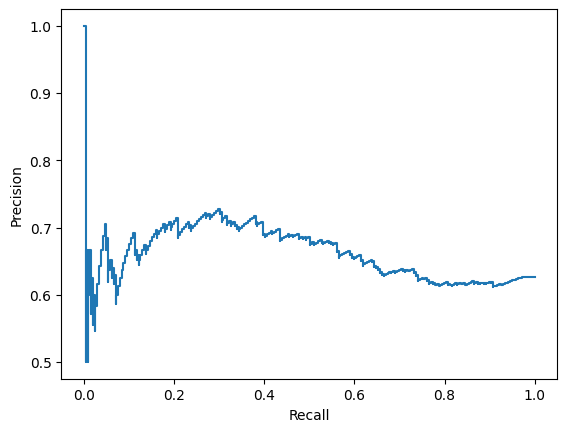

threshold: -1.0
f-score: 0.7697262479871175
precision: 1.0
recall: 0.6256544502617801
accuracy: 0.6178010471204188


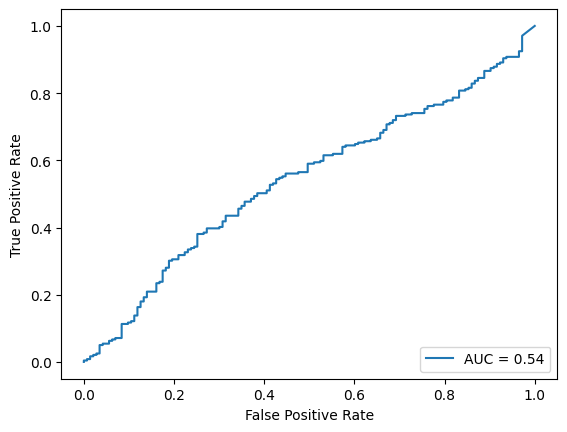

threshold: 0.5272802
accuracy: 0.5157068062827225
MCC: 0.1284838751442009


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, accuracy_score,
                             confusion_matrix, roc_auc_score, roc_curve,
                             matthews_corrcoef, auc,
                             RocCurveDisplay, PrecisionRecallDisplay, auc)

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print("threshold:", thresholds[ix])
print("f-score:", fscore[ix])
print("precision:", recall[ix])
print("recall:", precision[ix])

print("accuracy:", accuracy_score(y_true, y_pred>thresholds[ix]))

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

ix = np.argmax(tpr - fpr)
print("threshold:", thresholds[ix])
print("accuracy:", accuracy_score(y_true, y_pred>thresholds[ix]))
print("MCC:", matthews_corrcoef(y_true, y_pred>thresholds[ix]))